## Model selection 

Librairies

In [2]:
import utilities
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import re
import sklearn
import random
import textdistance
import umap

from sklearn.tree              import DecisionTreeClassifier
from sklearn.model_selection   import train_test_split
from sklearn                   import metrics
from sklearn.model_selection   import GridSearchCV
from transformers              import BertTokenizer, BertModel
from sentence_transformers     import SentenceTransformer
from sklearn.metrics           import roc_curve
from umap                      import UMAP
from typing                    import Optional
from sklearn.decomposition     import PCA
from sklearn.linear_model      import LogisticRegression

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\a.tekiouk\AppData\Local\Programs\Py

Import data

In [4]:
chanel_junk_valid_new = pd.read_excel('C:/Users/a.tekiouk/Sujet_2/Sujet_2/DATA/chanel_junk_valid_2.xlsx')
model = SentenceTransformer('all-MiniLM-L6-v2')
X = model.encode(chanel_junk_valid_new['text'])
y = chanel_junk_valid_new['is_junk']

Selection

In [5]:
def fit_params(
    X: pd.DataFrame,
    y: pd.Series,
    grid_params: dict,
    predictor = DecisionTreeClassifier(),
    hyperopt_params: Optional[dict] = None,
)-> dict:
    """
    Fits a given model on the provided dataset after reducing dimensions with the provided reducer.

    Parameters
    ----------
    X : pd.DataFrame
        The input DataFrame containing the features.
    y : pd.Series
        The target variable.
    grid_params : dict
        The dictionary of hyperparameter grids to search over using GridSearchCV.
    predictor : object, optional
        The model object implementing the scikit-learn estimator interface, by default DecisionTreeClassifier().
    hyperopt_params : dict, optional
        Additional parameters to be passed to the GridSearchCV for hyperparameter optimization, by default None.

    Returns
    -------
    dict
        The best parameters found by the hyperparameter optimization.
    """
    if hyperopt_params is None:
        hyperopt_params = {}
    
    # perform hyperopt with model on reduced data
    return (
        GridSearchCV(
            estimator=predictor,
            param_grid=grid_params,
            **hyperopt_params
        )
        .fit(X, y)
        .best_params_
    )
    
    # fit model with optimal parameters
    return predictor.set_params(**optimal_params).fit(X_reduced, y)

In [33]:
def auto_model_selection(
    X : pd.Series,
    y : pd.Series,
    dimension_range : range
    )-> tuple[object, float, int]:
    """
    Automatically selects the best model using dimensionality reduction techniques (PCA, UMAP)
    and evaluates their performance based on ROC AUC score.

    Parameters
    ----------
    X : pd.Series
        The input feature data.
    y : pd.Series
        The target variable.
    dimension_range : range
        The range of dimensions to explore for dimensionality reduction.

    Returns
    -------
    Tuple[object, float, int]
        A tuple containing the best model, the best ROC AUC score, and the optimal number of dimensions.
    """
    best_auc= 0
    # PCA DecisionTree
    for dim in dimension_range:
        reducer = PCA(n_components=dim)
        predictor = DecisionTreeClassifier(random_state = 42)
        X_reduced = reducer.fit(X).transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_reduced,y, test_size=0.2, random_state=42)
        opt_params = fit_params(
            X=X_train,
            y=y_train,
            predictor=predictor,
            grid_params={
                'criterion': ['entropy', 'gini', 'log_loss'],
                'max_depth' : np.arange(2, 6, dtype=int),
                'ccp_alpha' : np.linspace(0.0, 0.20, 5)
            },
            hyperopt_params={
                "scoring": "roc_auc",
                "cv": 5,
                "refit": True
            })
        model = predictor.set_params(**opt_params).fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = metrics.roc_curve(y_test, y_score)
        auc = metrics.auc(fpr, tpr)
        if(auc>best_auc):
            best_auc = auc
            best_model = model
            opt_nb_dim = dim
            y_t = y_test
            y_s = y_score
            y_p = y_pred
            recuc = reducer
    # UMAP DecisionTree
    for dim in dimension_range:
        reducer = UMAP(n_components=dim)
        predictor = DecisionTreeClassifier(random_state = 42)
        X_reduced = reducer.fit(X).transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_reduced,y, test_size=0.2, random_state=42)
        opt_params = fit_params(
            X=X_train,
            y=y_train,
            predictor=predictor,
            grid_params={
                'criterion': ['entropy', 'gini', 'log_loss'],
                'max_depth' : np.arange(2, 6, dtype=int),
                'ccp_alpha' : np.linspace(0.0, 0.20, 5)
            },
            hyperopt_params={
                "scoring": "roc_auc",
                "cv": 5,
                "refit": True
            })
        model = predictor.set_params(**opt_params).fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = metrics.roc_curve(y_test, y_score)
        auc = metrics.auc(fpr, tpr)
        if(auc>best_auc):
            best_auc = auc
            best_model = model
            opt_nb_dim = dim
            y_t = y_test
            y_s = y_score
            y_p = y_pred
            recuc = reducer
    # PCA Logistic Regression
    for dim in dimension_range:
        reducer = PCA(n_components=dim)
        predictor = LogisticRegression(random_state = 42,max_iter=1000)
        X_reduced = reducer.fit(X).transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_reduced,y, test_size=0.2, random_state=42)
        opt_params = fit_params(
            X=X_train,
            y=y_train,
            predictor=predictor,
            grid_params={
                'solver': ['lbfgs', 'liblinear', 'newton-cg','newton-cholesky','sag','saga']
            },
            hyperopt_params={
                "scoring": "roc_auc",
                "cv": 5,
                "refit": True
            })
        model = predictor.set_params(**opt_params).fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = metrics.roc_curve(y_test, y_score)
        auc = metrics.auc(fpr, tpr)
        if(auc>best_auc):
            best_auc = auc
            best_model = model
            opt_nb_dim = dim
            y_t = y_test
            y_s = y_score
            y_p = y_pred
            recuc = reducer
    # UMAP Logistic Regression
    for dim in dimension_range:
        reducer = UMAP(n_components=dim)
        predictor = LogisticRegression(random_state = 42,max_iter=1000)
        X_reduced = reducer.fit(X).transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_reduced,y, test_size=0.2, random_state=42)
        opt_params = fit_params(
            X=X_train,
            y=y_train,
            predictor=predictor,
            grid_params={
                'solver': ['lbfgs', 'liblinear', 'newton-cg','newton-cholesky','sag','saga']
            },
            hyperopt_params={
                "scoring": "roc_auc",
                "cv": 5,
                "refit": True
            })
        model = predictor.set_params(**opt_params).fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = metrics.roc_curve(y_test, y_score)
        auc = metrics.auc(fpr, tpr)
        if(auc>best_auc):
            best_auc = auc
            best_model = model
            opt_nb_dim = dim
            y_t = y_test
            y_s = y_score
            y_p = y_pred
            recuc = reducer
    return best_model,best_auc,reducer,opt_nb_dim,y_t,y_p,y_s

In [23]:
def evaluate(
    y_test: pd.Series,
    y_pred: pd.Series,
    y_score: pd.Series,
) -> None:
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score)
    print(f"AUC : {metrics.auc(fpr, tpr):.3f}")
    print(f"Accuracy score : {metrics.accuracy_score(y_test, y_pred):.3f}")
    print(f"Precision score : {metrics.precision_score(y_test, y_pred):.3f}")
    print(f"Recall score : {metrics.recall_score(y_test, y_pred):.3f}")
    utilities.plot_confusion_matrix(y_true=y_test, y_pred=y_pred)

In [36]:
best_model_auc,best_auc,opt_reducer,opt_dim,y_t,y_p,y_s = auto_model_selection(
    X=X,
    y=y,
    dimension_range=range(10,150))
best_model_auc,best_auc,opt_dim,opt_reducer

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
                  ^^

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
                  ^^

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
                  ^^

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
                  ^^

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
                  ^^

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
                  ^^

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
                  ^^

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
                  ^^

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
                  ^^

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
                  ^^

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
                  ^^

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
                  ^^

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
                  ^^

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
                  ^^

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_glm\_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.04107e-08): resul

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line 

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarnin

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_glm\_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_glm\_newton_solver.py:491: LinAlgWarning: The inner s

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line 

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line 

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line 

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_glm\_newton_solver.py:491: LinAlgWarning: The inner s

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_glm\_newton_solver.py:491: LinAlgWarning: The inner s

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_glm\_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=9.01084e-10): resul

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

(LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'),
 0.9380370872908186,
 59,
 UMAP(n_components=149, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}))

**model** :LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')  
**auc** : 0.9380370872908186  
**dimensions** : 59  

AUC : 0.938
Accuracy score : 0.870
Precision score : 0.794
Recall score : 0.818


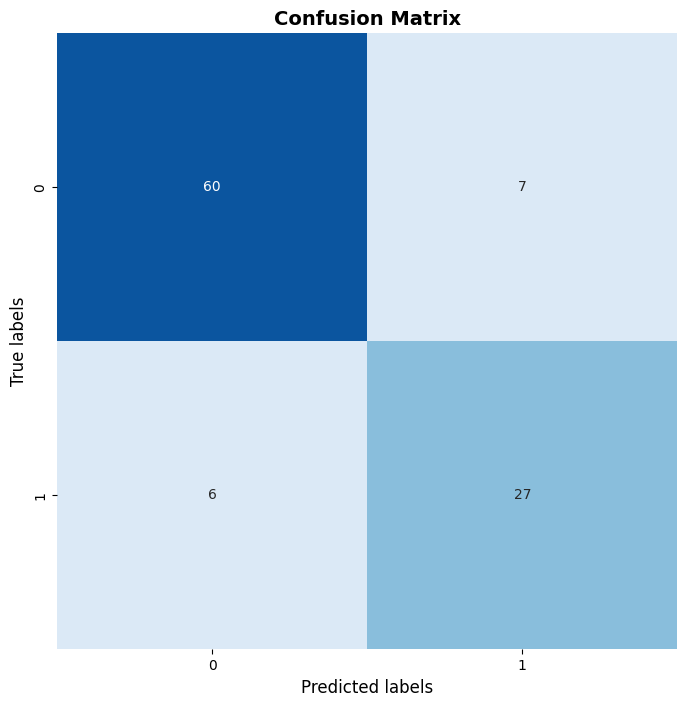

In [37]:
evaluate(y_t,y_p,y_s)

Optimization using precision

In [47]:
X_train, X_test, y_train, y_test = train_test_split(UMAP(n_components = opt_dim).fit(X).transform(X),y, test_size=0.2, random_state=42)
y_score = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear').fit(X_train,y_train).predict_proba(X_test)#[:, 1]

In [78]:
threshold = 0.50
y_p2 = y_p
while (metrics.recall_score(y_test, y_p2)>0.73):
    threshold = threshold+0.01
    y_p2 = np.where(y_score[:, 1] > threshold, 1, 0)

In [79]:
threshold

0.51

In [62]:
threshold

0.5

AUC : 0.938
Accuracy score : 0.860
Precision score : 0.828
Recall score : 0.727


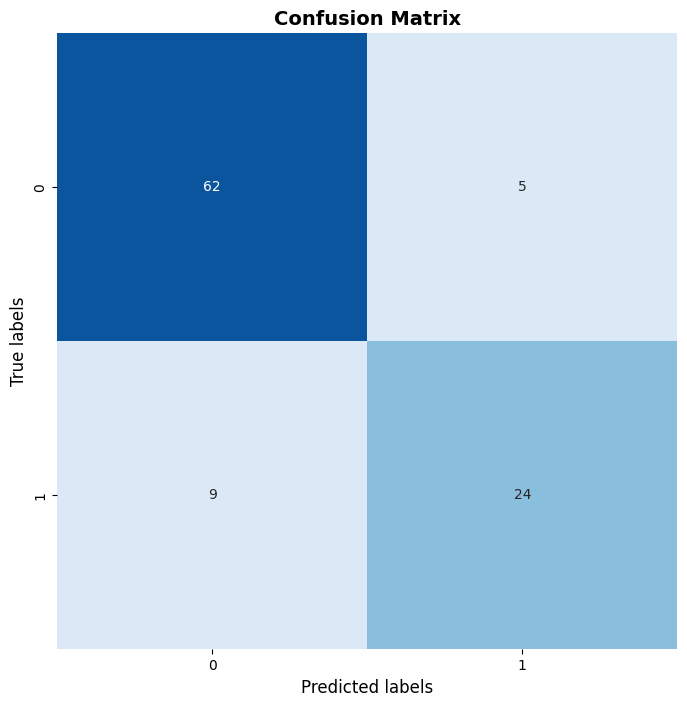

In [80]:
evaluate(y_t,y_p2,y_s)